In [1]:
import numpy as np
import networkx as nx
import json

import tqdm as tqdm

from simplequantnetsim.protocols import MPC_protocol, MPG_protocol, SP_protocol
from simplequantnetsim.graph import network, set_edge_length, update_graph_params, reset_graph_state, reset_graph_usage, remove_nodes

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from networkx.drawing.layout import *
from networkx.readwrite import json_graph

# Helpers

## Draw network

In [2]:
draw_options = {
    "l": {
        "with_labels": True,
        "node_size": 1000,
        "font_size": 10,
        "label_offset": 0.25,
        "label_size": 8
    }, # 5x5
    "m": {
        "with_labels": True,
        "node_size": 500,
        "font_size": 8,
        "label_offset": 0.35,
        "label_size": 6
    }, # 9x9
    "s": {
        "with_labels": False,
        "node_size": 250,
        "font_size": 0,
        "label_offset": 0,
        "label_size": 6
    }, # 15x15
    "xs": {
        "with_labels": False,
        "node_size": 80,
        "font_size": 0,        
        "label_offset": 0,        
        "label_size": 4
    } # 25x25
}

def draw_network(D, size="l"):
    usage = nx.get_node_attributes(D, "usage_fraction")
    pos = dict((n, n) for n in D.nodes())  # grid layout

    cmap = plt.cm.Blues
    cmap.set_under(color="white")  # display zero fraction (under 0.0000001) as white

    nc = nx.draw(
        D,
        pos=pos,
        with_labels=draw_options[size]["with_labels"],
        node_size=draw_options[size]["node_size"],
        font_size=draw_options[size]["font_size"],
        node_color=list(usage.values()),
        vmin=0.0000001,
        cmap=cmap,
    )

    # colorbar
    ax = plt.gca()
    PCM = ax.get_children()[0]
    cbar = plt.colorbar(PCM, ax=ax)
    cbar.set_label(
        "Usage fraction (/rep)", rotation=270, fontsize=12, labelpad=15
    )

    # usage labels
    pos_usage = {}
    for node, coords in pos.items():
        pos_usage[node] = (coords[0] + draw_options[size]["label_offset"], coords[1] - draw_options[size]["label_offset"])

    rounded_usage = {}
    for node, attr in usage.items():
        rounded_usage[node] = round(attr, 2)

    nx.draw_networkx_labels(D, pos_usage, labels=rounded_usage, font_size=draw_options[size]["label_size"])

## Plot ER v min usage

In [3]:
def plot_removed_repeaters(min_usage_range, ER_range, repeaters_removed, base_ER):
    fontsize = 12
    plt.figure(figsize=(10, 6), dpi=600)
    plt.grid(linewidth=0.5)

    ax = plt.gca()
    sc = ax.scatter(min_usage_range, ER_range, c=repeaters_removed, marker="x", s=40)

    plt.tick_params(labelsize=fontsize)
    plt.xlabel("Minimum usage fraction (/rep)", fontsize=fontsize)
    plt.ylabel("ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

    for i, txt in enumerate(repeaters_removed):
        ax.annotate(
            txt,
            xy=(min_usage_range[i], ER_range[i]),
            xycoords="data",
            xytext=(3, -6),
            textcoords="offset points",
            fontsize=6,
            weight='bold'
        )

    # plot original ER
    plt.axhline(
        y=base_ER,
        color="black",
        linestyle="--",
        linewidth="1",
        label="Base ER",
    )
    plt.legend(fontsize=10)

    cbar = plt.colorbar(sc)
    cbar.set_label(
        "No. repeaters removed", rotation=270, fontsize=12, labelpad=15
    )

## Plot ER v Length

In [4]:
def plot_er_len(repeaters_removed_list, ER_list, lengths, loss_dB, p_op, x_lim=30):
    fontsize = 12
    cols = ["gray", "g", "b", "orange", "r", "k", "purple"] + ["k"] * 100

    plt.figure(figsize=(8, 6), dpi=600)
    plt.grid(linewidth=0.5)
    
    for i in range(len(repeaters_removed_list)):
        y = plt.plot(
            lengths,
            ER_list[i],
            color=cols[i],
            marker="x",
            linestyle="None",
            markersize=3,
            label=repeaters_removed_list[i],
        )
    plt.yscale("log")
    plt.legend(fontsize=10, title="No. repeaters removed", title_fontsize=8)

    plt.tick_params(labelsize=fontsize)

    plt.xlabel("Edge length (km)", fontsize=fontsize)
    plt.ylabel("ER ($\mathregular{GHZ}_5/\ \\mathregular{T_{slot}}$)", fontsize=fontsize)

    ax = plt.gca()
    l_ticks = ax.get_xticks()
    ax.set_xlim([0, x_lim])
    ax.set_ylim([0.0001, 1])

    length2p_ph = lambda l: 10 ** -(loss_dB * l / 10)
    p_ph2length = lambda p: -(np.log10(p) * 10) / loss_dB
    ax2 = ax.secondary_xaxis(-0.15, functions=(length2p_ph, p_ph2length))
    ax2.set_xlabel("Photon transmission probability $p_{ph}$", fontsize=fontsize)
    p_ph_ticks = length2p_ph(l_ticks)
    ax2.set_xticks(p_ph_ticks)
    ax2.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax2.xaxis.set_tick_params(labelsize=fontsize)

    length2p_e = lambda l: length2p_ph(l) * p_op
    p_e2length = lambda p: p_ph2length(p / p_op)
    ax3 = ax.secondary_xaxis(-0.3, functions=(length2p_e, p_e2length))
    ax3.set_xlabel("Entanglement link generation probability $p_e$", fontsize=fontsize)
    p_e_ticks = length2p_e(l_ticks)
    ax3.set_xticks(p_e_ticks)
    ax3.xaxis.set_major_formatter(FormatStrFormatter("%.2f"))
    ax3.xaxis.set_tick_params(labelsize=fontsize)

## Save and load data

In [3]:
def save_data(filename, data):
    with open("data/" + filename + ".json", "w") as file:
        file.write(json.dumps(data))

def load_data(filename):
    with open("data/" + filename + ".json", "r") as file:
        return json.loads(file.read())

# Usage

In [10]:
size = 5
center = (size - 1) / 2
timesteps = 5000
reps = 1000
length = 1
Q_c = 1
p_op = 1
loss_dB = 0.2
protocol = MPC_protocol

H = network(size, size)
users = [
    (center, center),
    (0, 0),
    (0, size - 1),
    (size - 1, 0),
    (size - 1, size - 1),
]  # "source" for SP & MPG will be the central node
update_graph_params(H, Qc=Q_c)

set_edge_length(H, length, p_op)
er, multipartite_gen_time, links_used = protocol(H, users, timesteps, reps, count_fusion=True)

## Draw network

In [39]:
nodes = H.nodes(data=True)

print(nodes)
usage = nx.get_node_attributes(H, "usage_fraction")
print(list(usage.values()))

[((0, 0), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 1), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 2), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 3), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 4), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 5), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 6), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 7), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((0, 8), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((1, 0), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fraction': 0.0}), ((1, 1), {'Qc': 1, 'entangled': False, 'age': 0, 'usage_count': 0, 'usage_fract

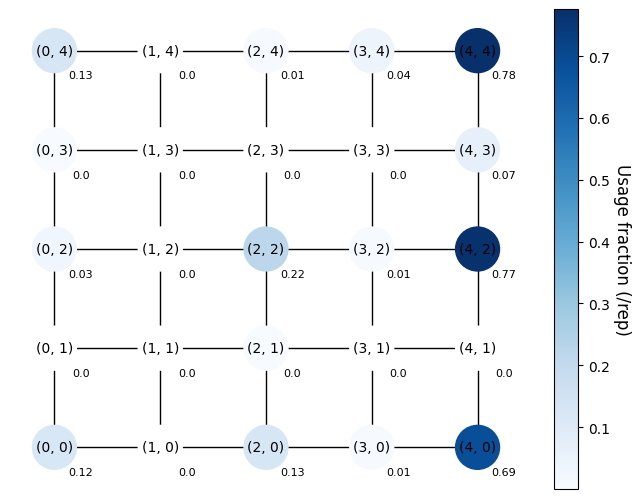

In [11]:
draw_network(H, "l")
plt.savefig("figures/usage.png", dpi=600, bbox_inches="tight")

## Save data

In [9]:
data_to_save = {
    "protocol": str(protocol).split(" ")[1],
    "size": size,
    "length": length,
    "Q_c": Q_c,
    "p_op": p_op,
    "loss_dB": loss_dB,
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "ER": er,
    "links_used": links_used,
    "network_data": json_graph.node_link_data(H),
}

save_data("usage/method_reps/5x5/fusion_only/L1", data_to_save)

## Load and plot data

In [14]:
file_to_open = "usage/method_reps/15x15/MPG_L1"

with open("data/" + file_to_open + ".json", "r") as file:
    loaded_data = json.loads(file.read())

H_loaded = json_graph.node_link_graph(loaded_data["network_data"])

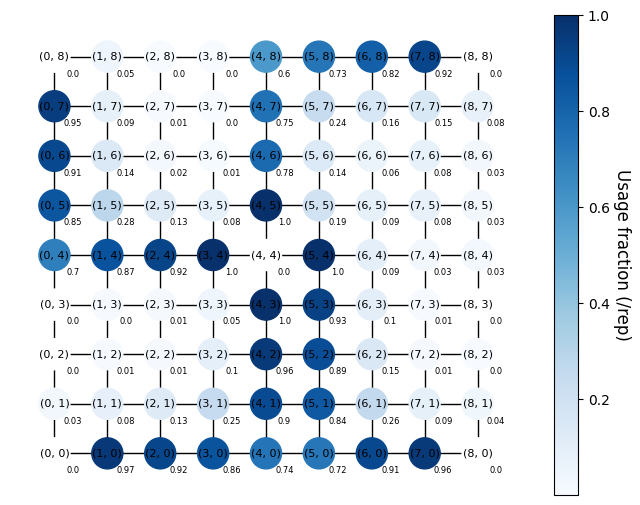

In [15]:
draw_network(H_loaded, "m")
plt.savefig("figures/usage2.png", dpi=600, bbox_inches="tight")

# Removing Repeaters

## Individual cases

In [68]:
loaded_data = load_data("usage/method_reps/15x15/MPC_L1_fusion")

In [69]:
N_loaded = json_graph.node_link_graph(loaded_data["network_data"])
users = [tuple(user) for user in loaded_data["users"]]
min_usage = 0.3

num_removed = remove_nodes(N_loaded, min_usage, users)

print(num_removed)

reset_graph_state(N_loaded)
reset_graph_usage(N_loaded)

155


In [44]:
timesteps = 5000
reps = 1000
protocol = MPC_protocol
er, multipartite_gen_time, links_used = protocol(N_loaded, users, timesteps, reps, count_fusion=True)
print(er)

0.5324813631522897


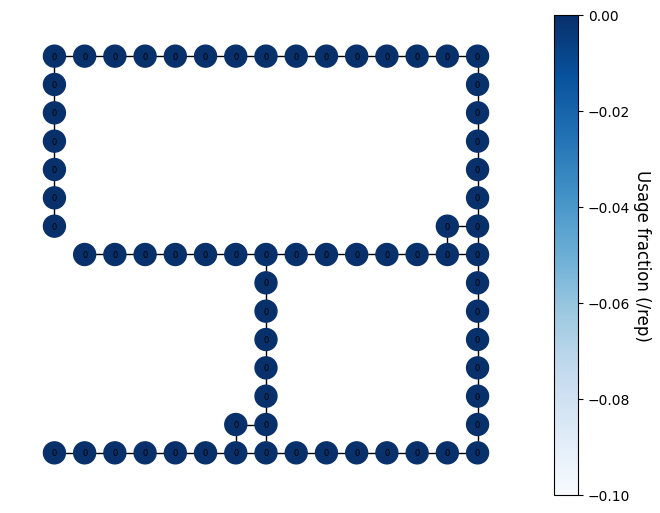

In [70]:
draw_network(N_loaded, "s")
plt.savefig("figures/usage.png", dpi=600, bbox_inches="tight")

In [46]:
data_to_save = {
    "min_usage": min_usage,
    "num_removed": num_removed,
    "protocol": str(protocol).split(" ")[1],
    "size": loaded_data["size"],
    "length": loaded_data["length"],
    "Q_c": loaded_data["Q_c"],
    "p_op": loaded_data["p_op"],
    "loss_dB": loaded_data["loss_dB"],
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "ER": er,
    "links_used": links_used,
    "network_data": json_graph.node_link_data(N_loaded),
}

save_data("remove_repeaters/usage/5x5/MPC_0.3", data_to_save)

## Cut-off range

In [77]:
# loaded_data = load_data("usage/method_reps/25x25/MPG_L1")
loaded_data = load_data("usage/method_reps/25x25/MPC_L1_fusion")

In [78]:
timesteps = 5000
reps = 1000
protocol = MPC_protocol
users = [tuple(user) for user in loaded_data["users"]]

min_usage_range = np.linspace(0, 0.3, 31)
num_removed = np.zeros(len(min_usage_range), dtype=int)
ER = np.zeros(len(min_usage_range))
links_used = np.zeros(len(min_usage_range))

for i, min_usage in enumerate(tqdm.tqdm(min_usage_range)):  # tqdm_notebook
    N_loaded = json_graph.node_link_graph(loaded_data["network_data"])

    removed = remove_nodes(N_loaded, min_usage, users)
    num_removed[i] = removed

    reset_graph_state(N_loaded)
    reset_graph_usage(N_loaded)

    er, multipartite_gen_time, links = protocol(N_loaded, users, timesteps, reps, count_fusion=True)
    ER[i] = er
    links_used[i] = links

100%|██████████| 31/31 [1:50:26<00:00, 213.76s/it]  


### Plot 

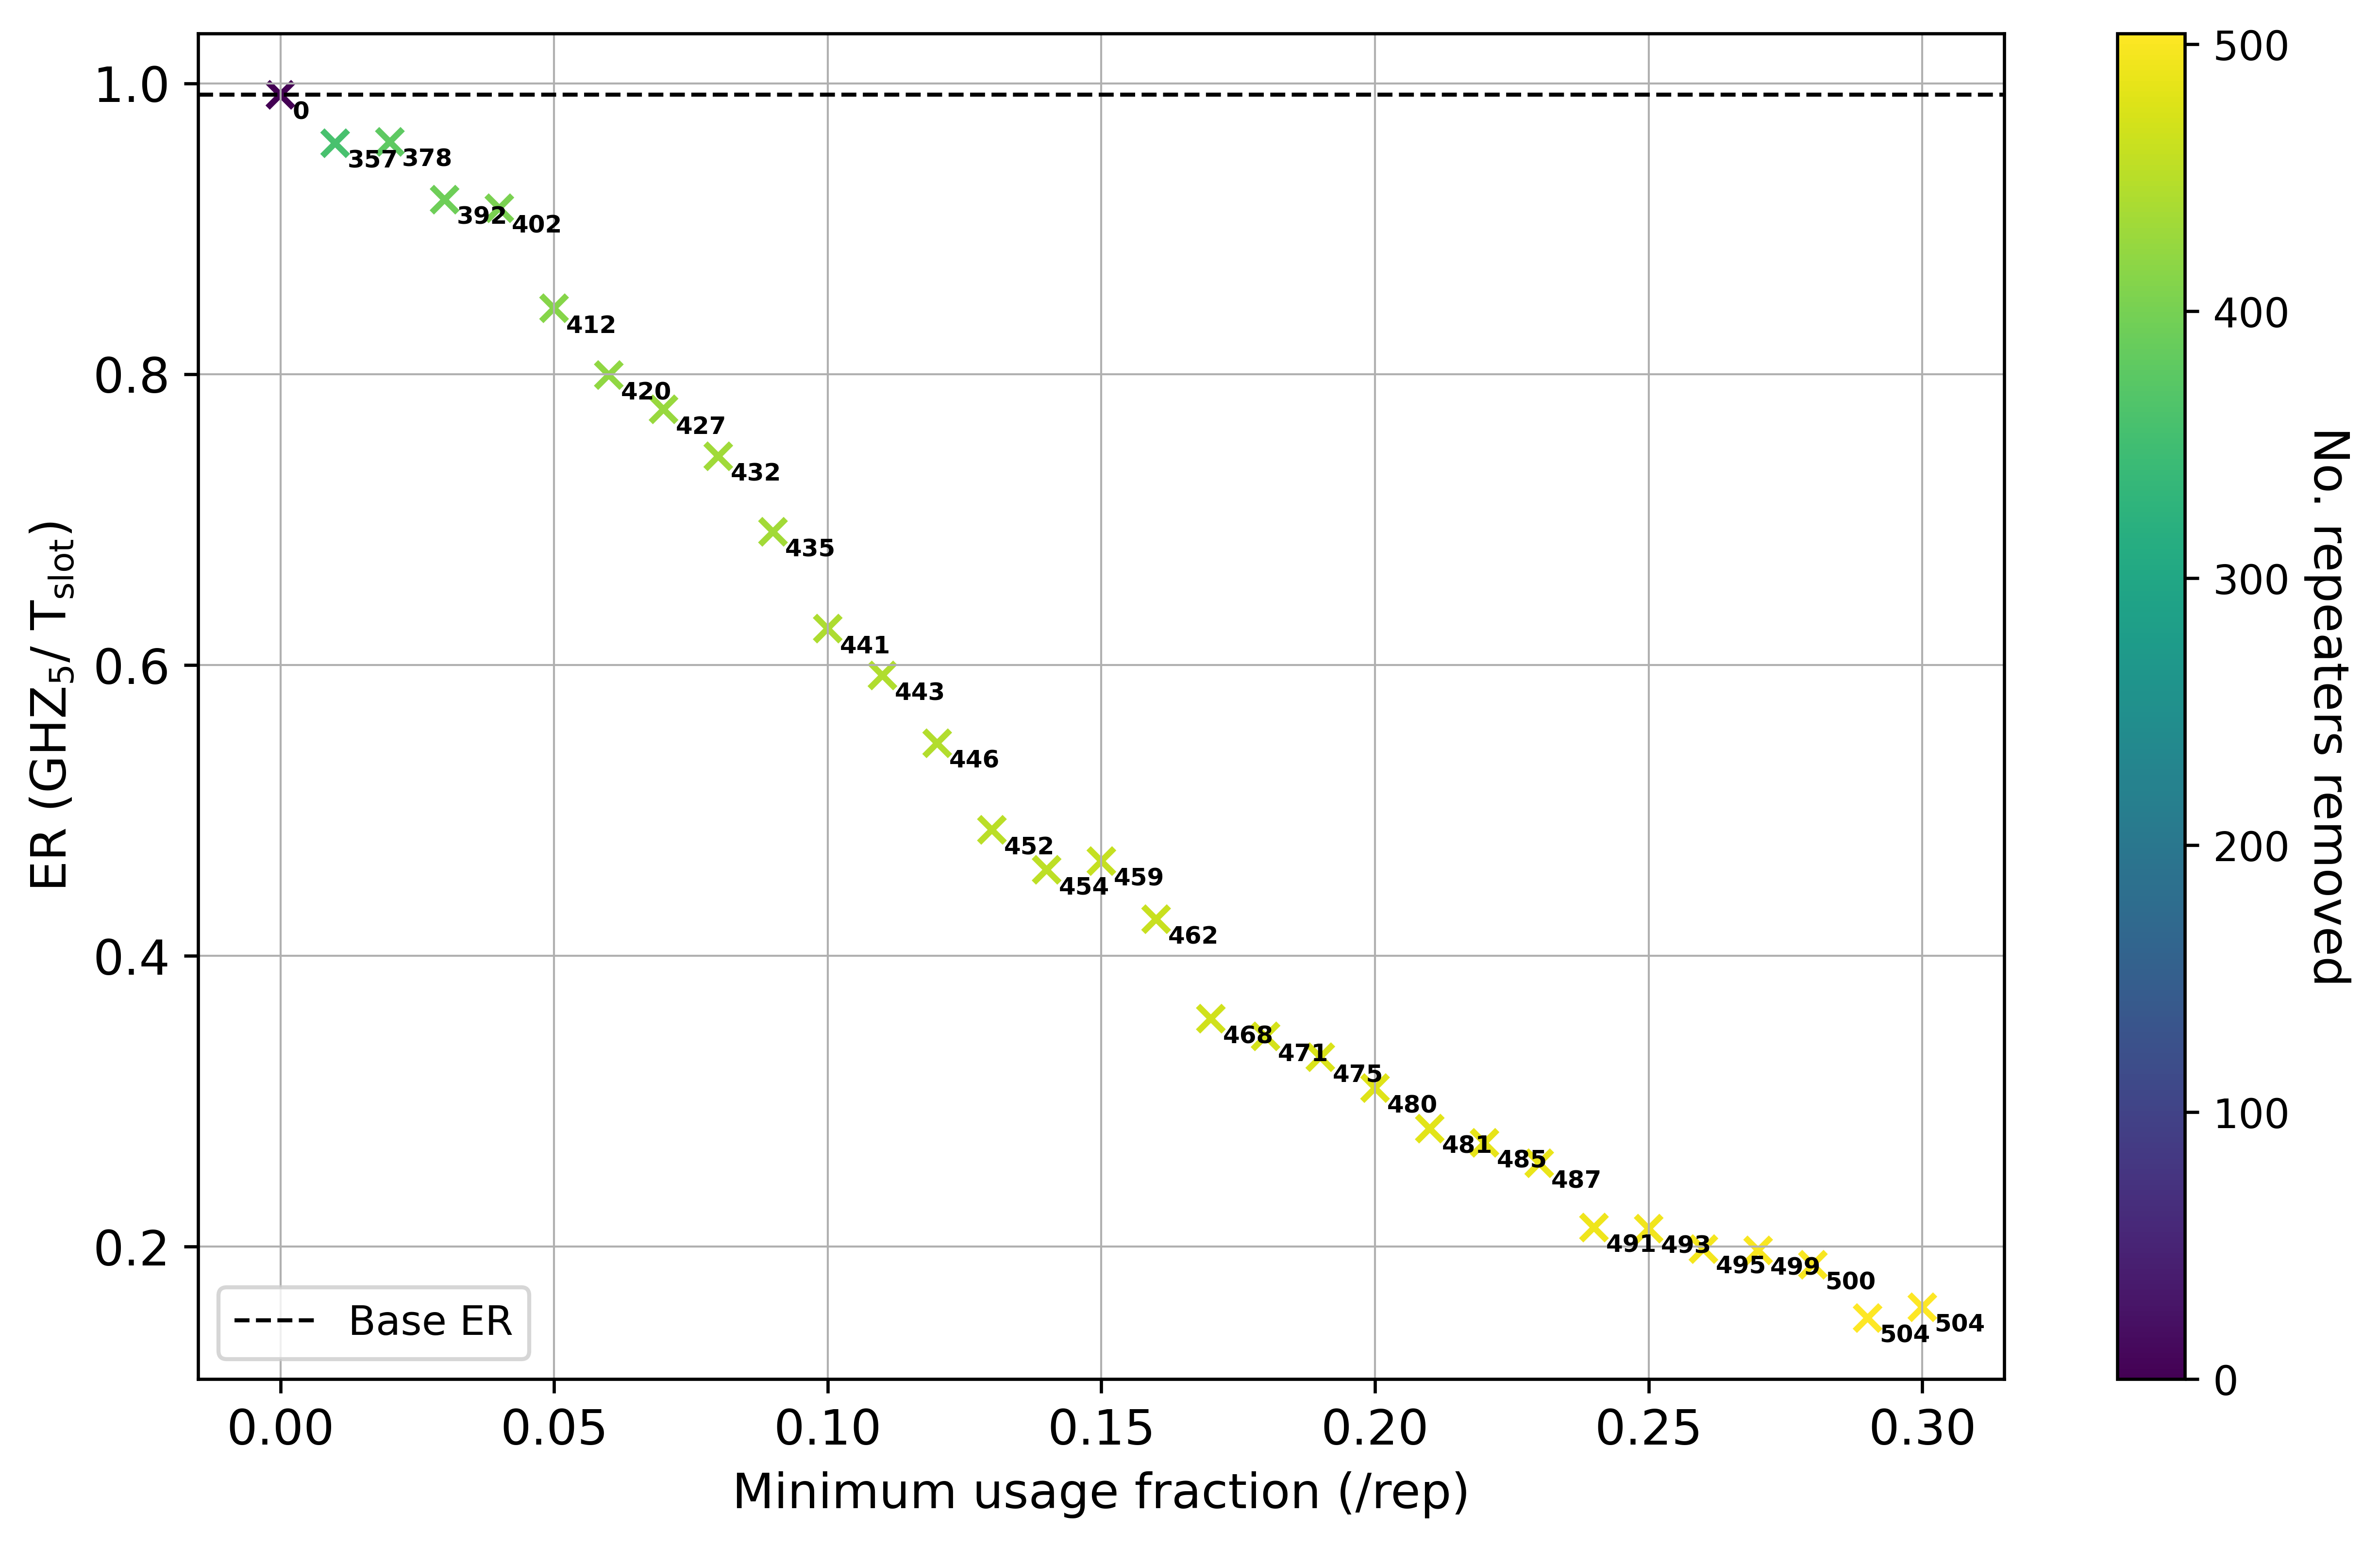

In [79]:
plot_removed_repeaters(
    min_usage_range,
    ER,
    num_removed,
    loaded_data["ER"],
)
plt.savefig("figures/removed_repeaters.png", dpi=600, bbox_inches="tight")

### Save

In [80]:
data_to_save = {
    "min_usage_range": min_usage_range.tolist(),
    "num_removed": num_removed.tolist(),
    "protocol": str(protocol).split(" ")[1],
    "size": loaded_data["size"],
    "length": loaded_data["length"],
    "Q_c": loaded_data["Q_c"],
    "p_op": loaded_data["p_op"],
    "loss_dB": loaded_data["loss_dB"],
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "ER": ER.tolist(),
    "base_ER": loaded_data["ER"],
    "links_used": links_used.tolist(),
}

save_data("remove_repeaters/usage/25x25/MPC_range", data_to_save)

### Load and plot

In [26]:
loaded_removed_data = load_data("remove_repeaters/usage/5x5/MPC_range")

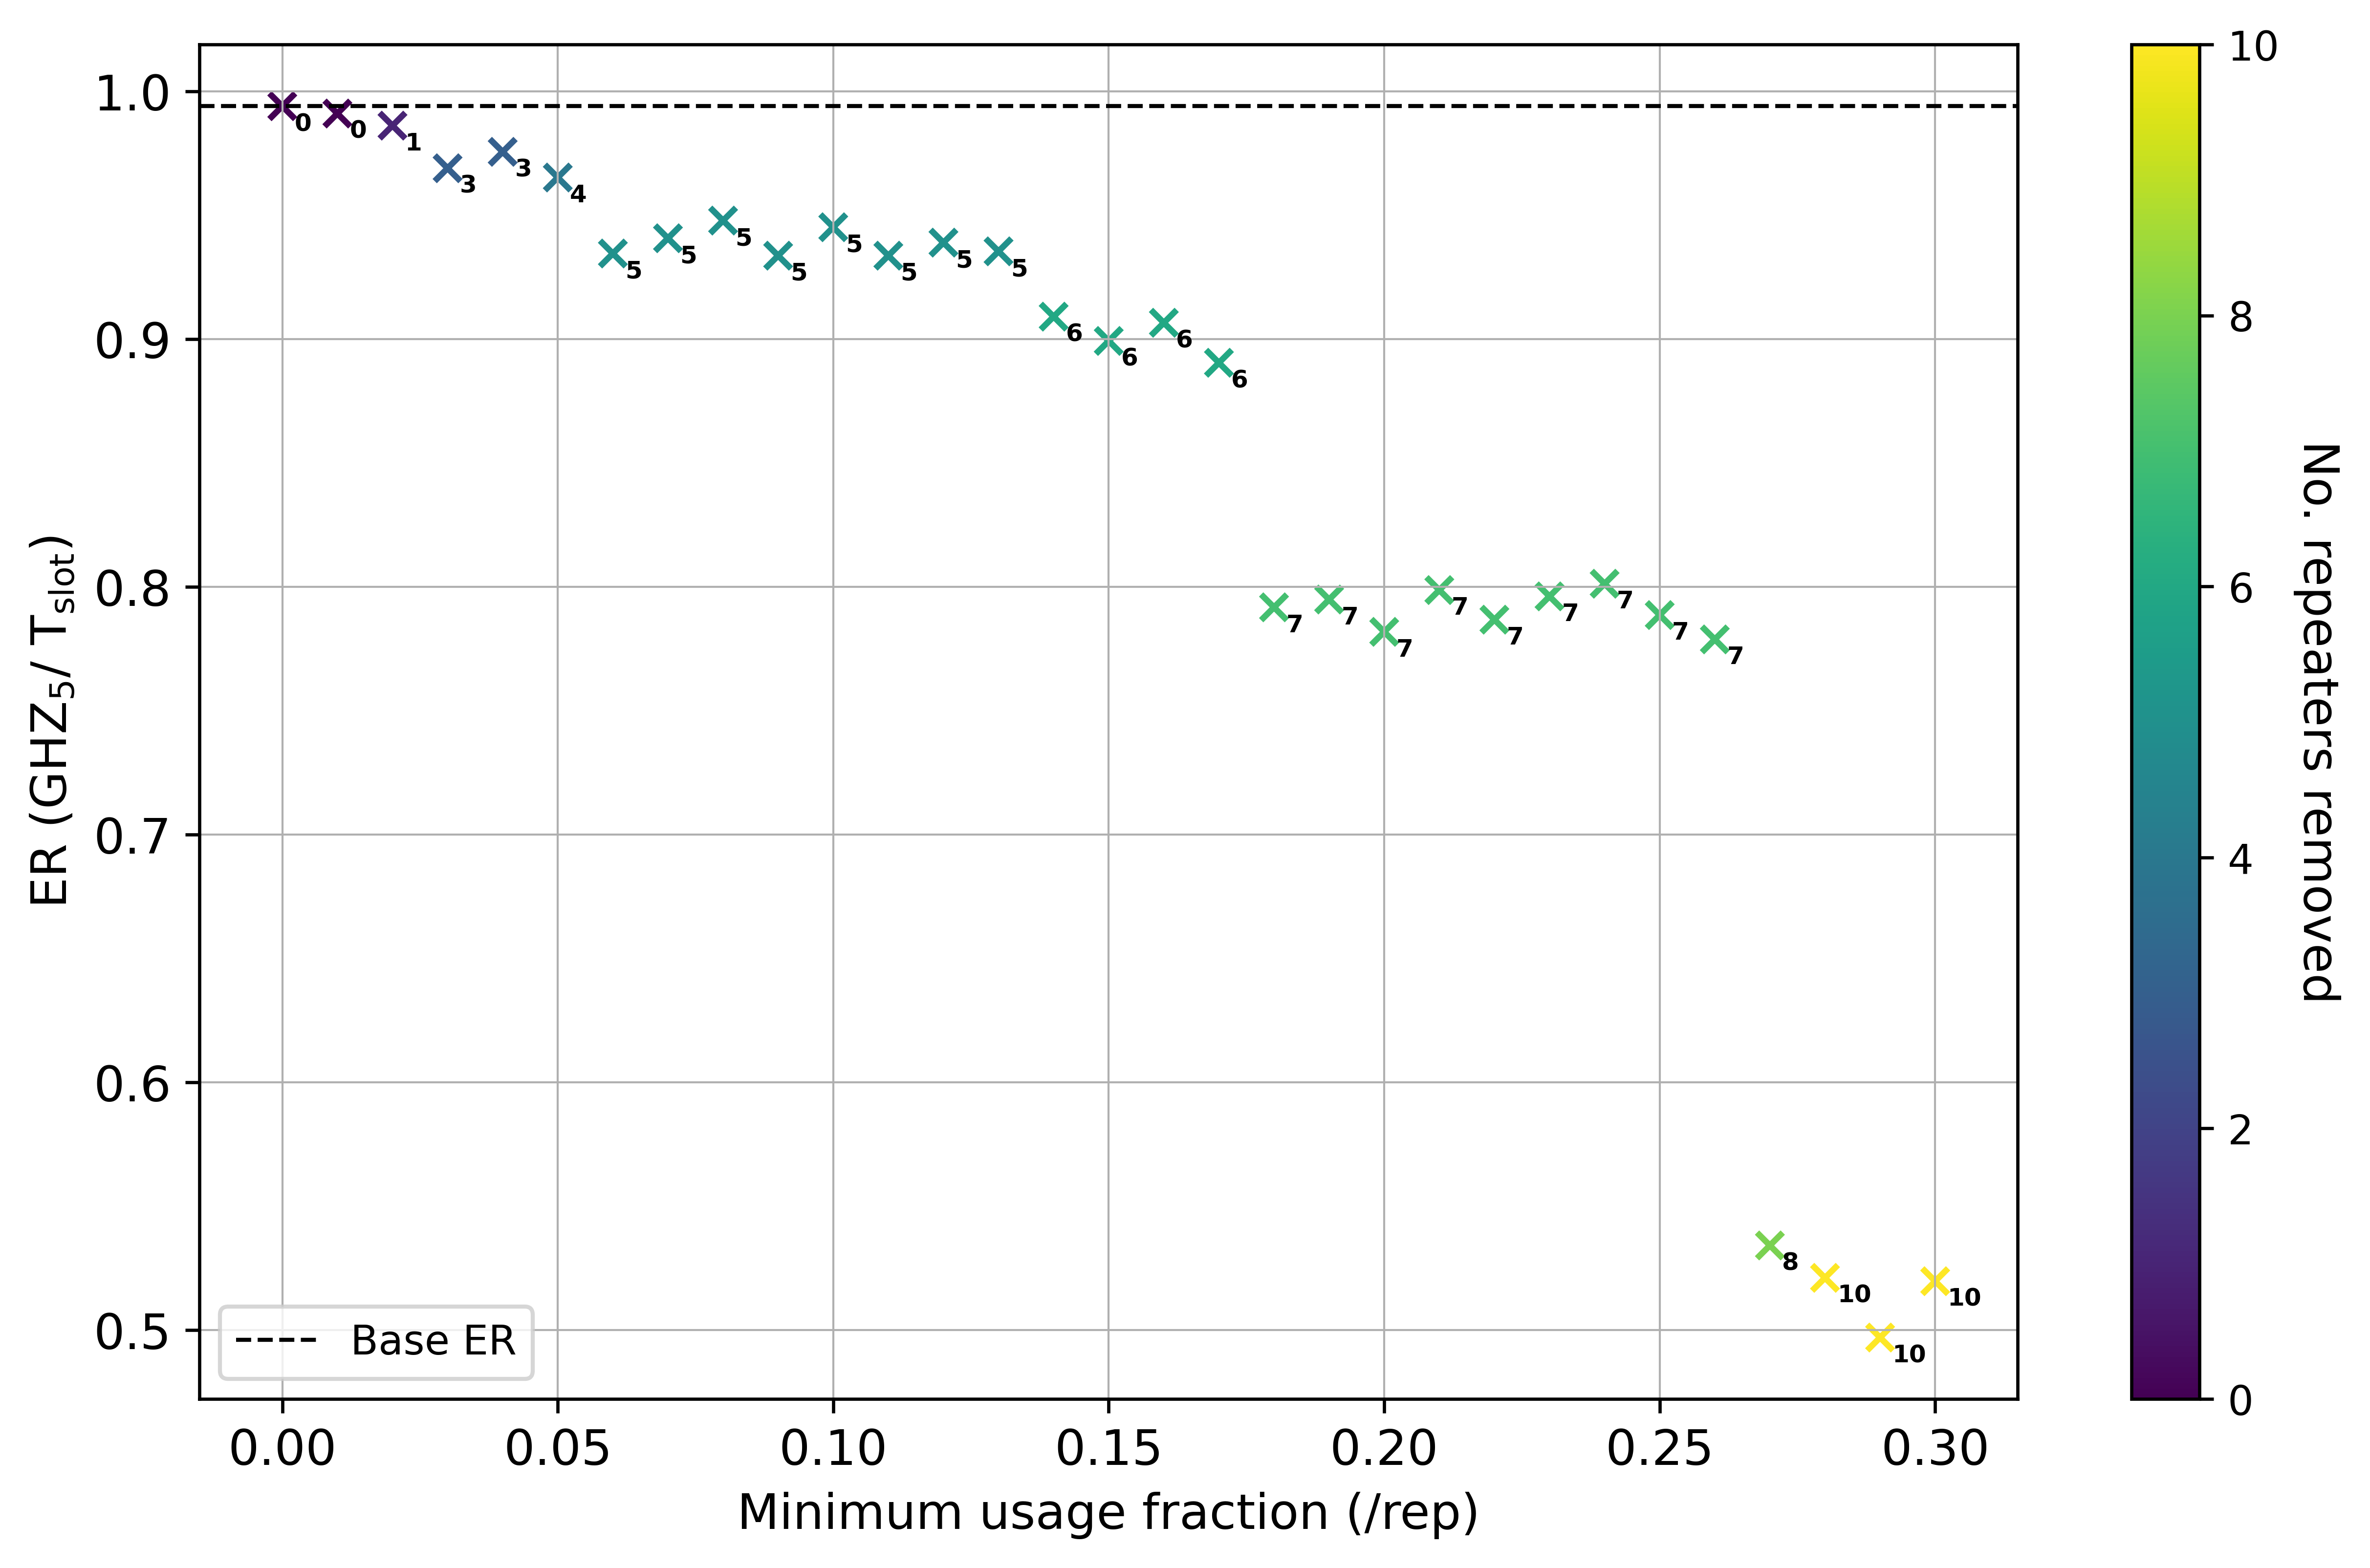

In [27]:
plot_removed_repeaters(
    loaded_removed_data["min_usage_range"],
    loaded_removed_data["ER"],
    loaded_removed_data["num_removed"],
    loaded_removed_data["base_ER"],
)
plt.savefig("figures/removed_repeaters2.png", dpi=600, bbox_inches="tight")

## ER v Length 

In [110]:
loaded_data = load_data("usage/method_reps/25x25/MPC_L1_fusion")

In [111]:
timesteps = 1000
reps = 200
protocol = MPC_protocol
p_op = loaded_data["p_op"]
loss_dB = loaded_data["loss_dB"]
users = [tuple(user) for user in loaded_data["users"]]

min_usage_options = np.array([0, 0.03, 0.1, 0.2, 0.3])
num_removed = np.zeros(len(min_usage_options), dtype=int)

length_range = np.linspace(0, 30, 100)
ER = np.zeros((len(min_usage_options), len(length_range)))
links_used = np.zeros((len(min_usage_options), len(length_range)))

for i, min_usage in enumerate(min_usage_options):  
    N_loaded = json_graph.node_link_graph(loaded_data["network_data"])
    removed = remove_nodes(N_loaded, min_usage, users)
    num_removed[i] = removed

    for j, length in enumerate(tqdm.tqdm(length_range)):  # tqdm_notebook
        set_edge_length(N_loaded, length, p_op=p_op, loss_dB=loss_dB)
        reset_graph_state(N_loaded)
        reset_graph_usage(N_loaded)

        if (length > 17):
            break

        er, multipartite_gen_time, links = protocol(N_loaded, users, timesteps=timesteps, reps=reps, count_fusion=True)
        ER[i, j] += er
        links_used[i, j] = links

 57%|█████▋    | 57/100 [36:03<27:12, 37.96s/it]  


In [112]:
data_to_save = {
    "min_usage_options": min_usage_options.tolist(),
    "num_removed": num_removed.tolist(),
    "protocol": str(protocol).split(" ")[1],
    "size": loaded_data["size"],
    "Q_c": loaded_data["Q_c"],
    "p_op": loaded_data["p_op"],
    "loss_dB": loaded_data["loss_dB"],
    "timesteps": timesteps,
    "reps": reps,
    "users": users,
    "datapoints": length_range.size,
    "length_range": length_range.tolist(),
    "ER": ER.tolist(),
    "links_used": links_used.tolist(),
}

save_data("remove_repeaters/ER_len/25x25/MPC", data_to_save)

In [113]:
ER_len_data = load_data("remove_repeaters/ER_len/25x25/MPC")

/var/folders/mh/0kqg0hkj7l1502tj51x6g8jw0000gn/T/ipykernel_63102/2109315760.py:32: RuntimeWarning: divide by zero encountered in log10
  p_ph2length = lambda p: -(np.log10(p) * 10) / loss_dB


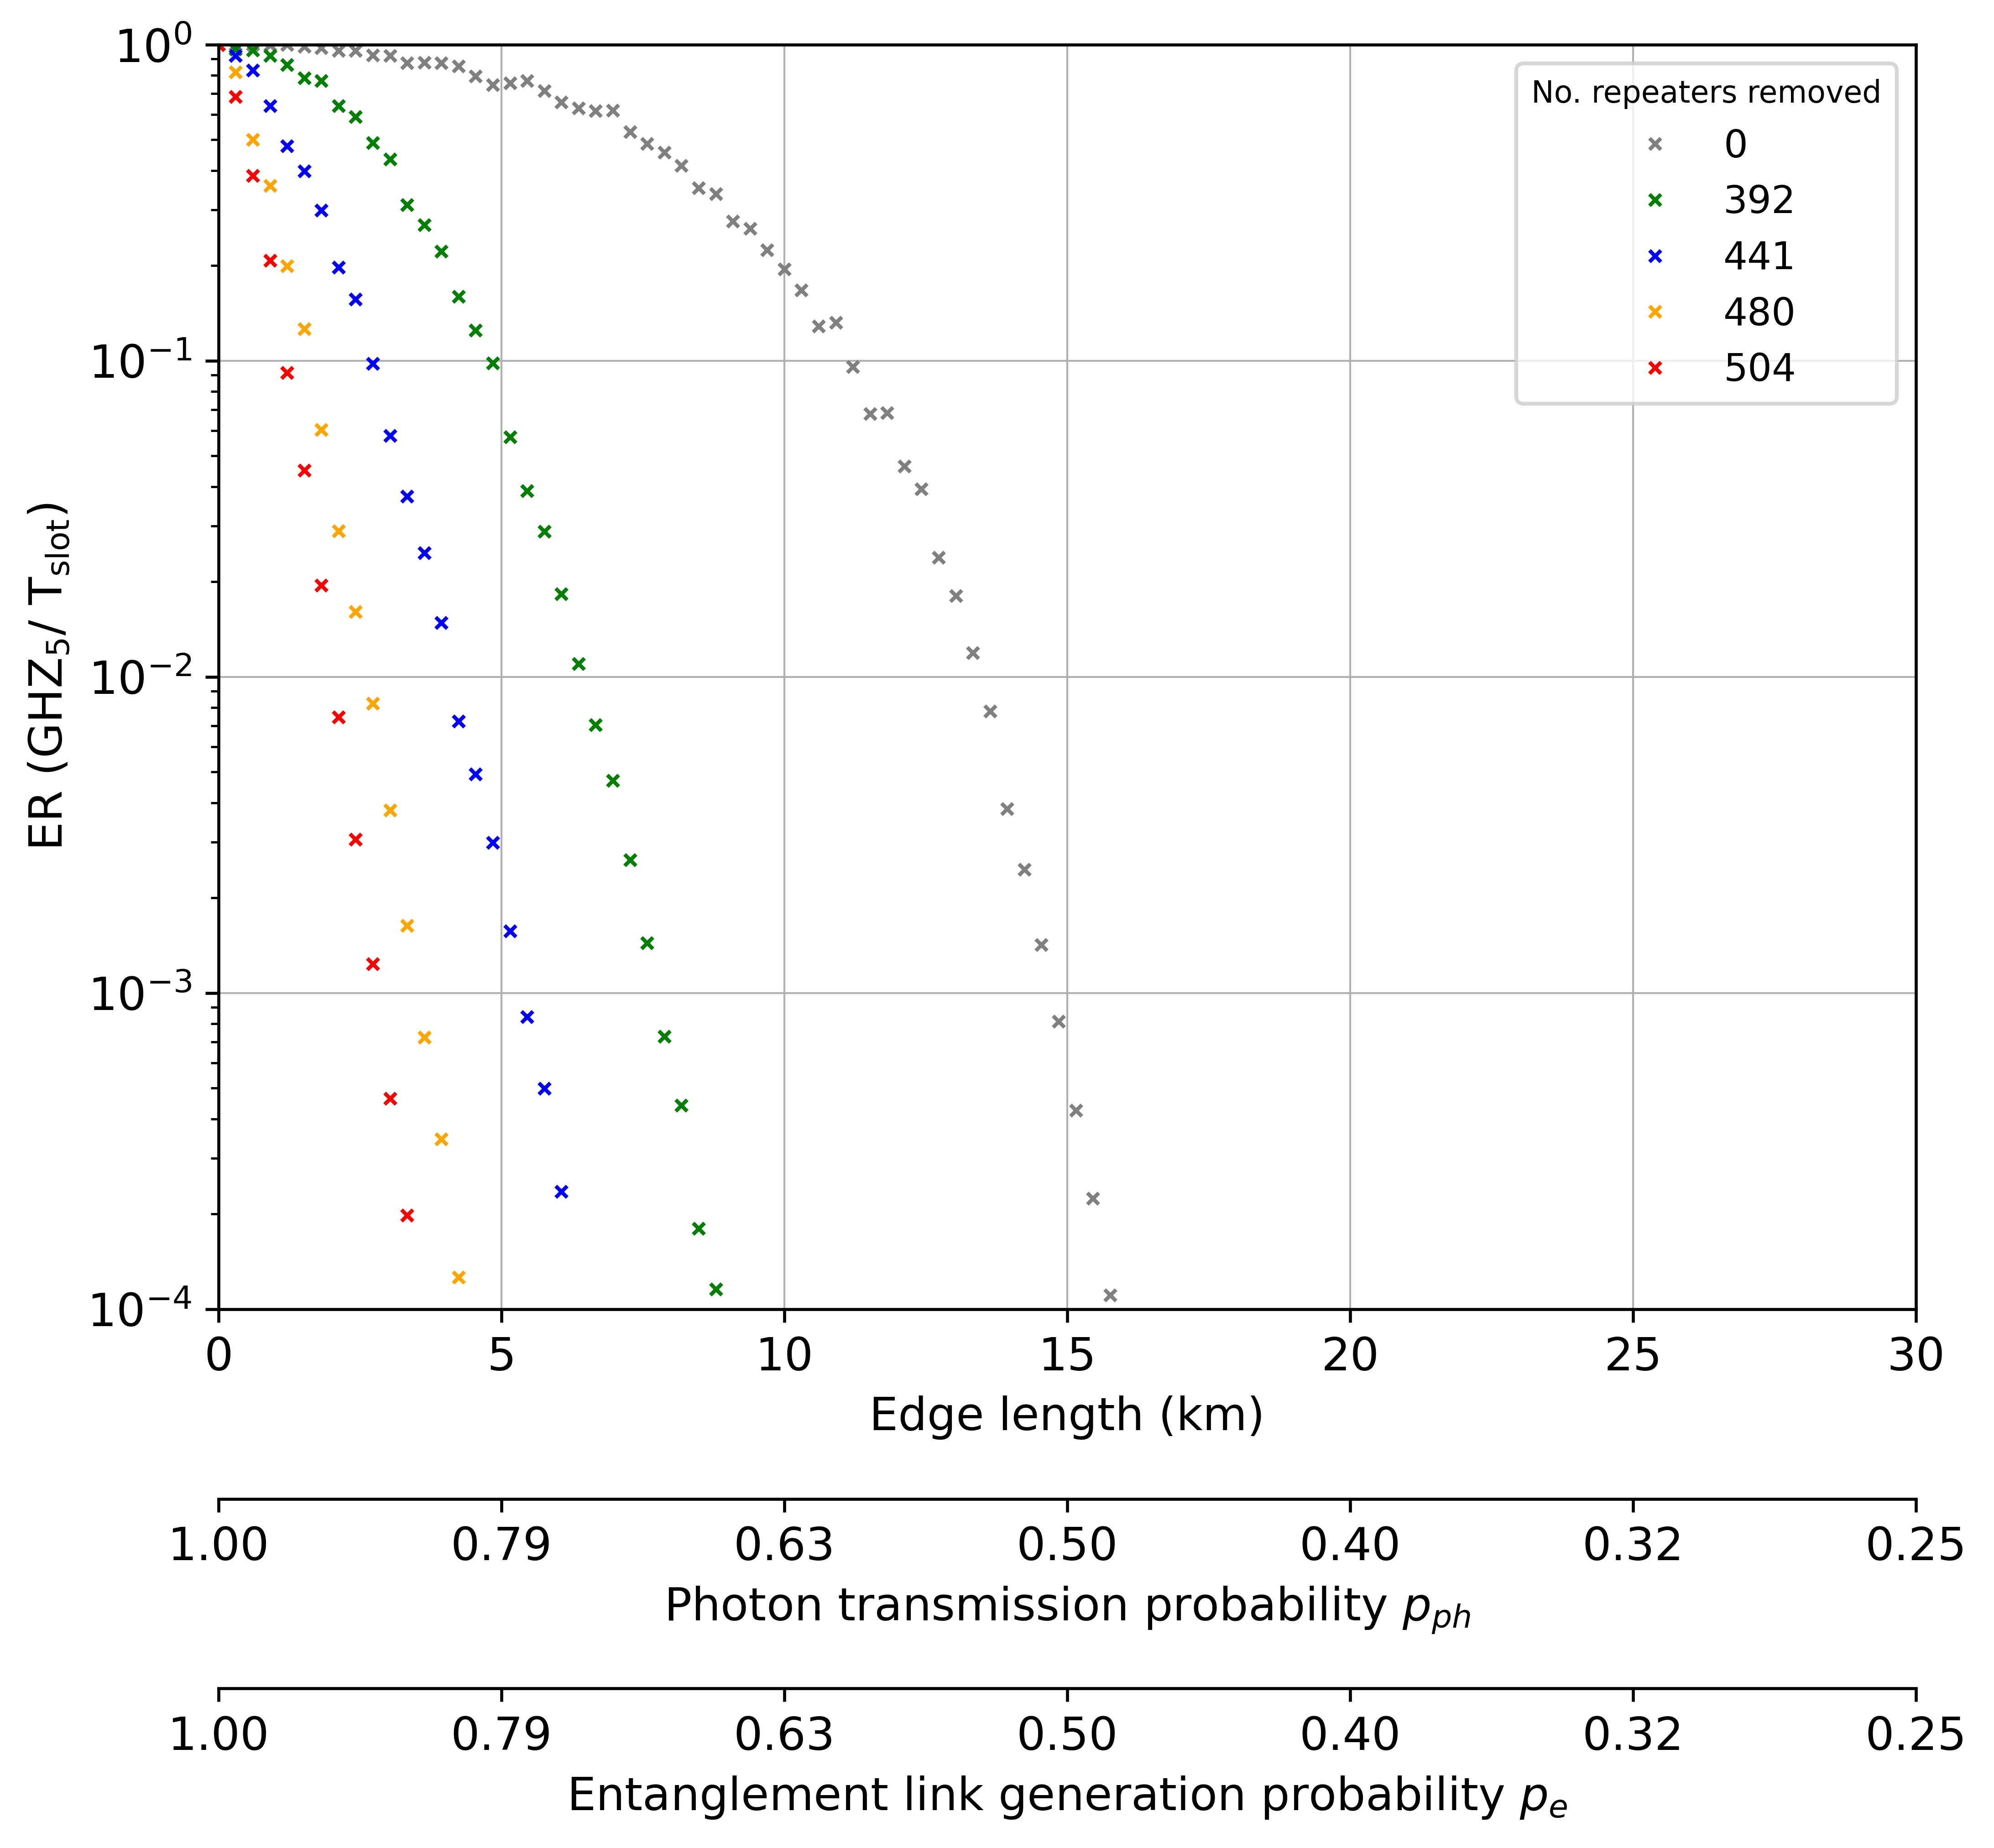

In [114]:
plot_er_len(num_removed, ER, length_range, loss_dB=loaded_data["loss_dB"], p_op=loaded_data["p_op"], x_lim=30)
# plot_er_len(ER_len_data["num_removed"], ER_len_data["ER"], ER_len_data["length_range"], loss_dB=ER_len_data["loss_dB"], p_op=ER_len_data["p_op"], x_lim=30)
plt.savefig("figures/ER_v_length.png", dpi=600, bbox_inches="tight")